### Bead max peaks intensity analysis

#### Imports

In [1]:
from tifffile import TiffFile
import re
import pandas as pd
from tqdm import tqdm
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters

In [2]:
sys.path.append(r'C:\Users\97254\Desktop\git\FluoroVision\src')

In [3]:
from utils.common_utils import xywh_to_x1y1x2y2, extract_frame_number
from config.const import BEAD_WIDTH_THRESHOLD


##### Functions

In [4]:
def get_2d_peaks(image, min_distance=10):
    # Apply maximum filter
    neighborhood = filters.maximum_filter(image, size=min_distance)
    # Find local maxima
    local_max = (image == neighborhood)
    # Get the coordinates of the peaks
    peak_coords = np.argwhere(local_max)
    # Sort peaks by intensity
    peak_intensities = image[local_max]
    return peak_intensities, peak_coords

#### Inputs

In [5]:
video_path1 = r'C:\Users\97254\Desktop\Resources\Technion\exploratory_resaerach\data\AB3C.tif'
annotation_path1 = r'C:\Users\97254\Desktop\Resources\Technion\exploratory_resaerach\data\AB3C_gt_new_format.csv'

video_path2 = r'C:\Users\97254\Desktop\Resources\Technion\exploratory_resaerach\data\AB4C.tif'
annotation_path2 = r'C:\Users\97254\Desktop\Resources\Technion\exploratory_resaerach\data\AB4C_gt_new_format.csv'

video_path3 = r'C:\Users\97254\Desktop\Resources\Technion\exploratory_resaerach\data\AB5C.tif'
annotation_path3 = r'C:\Users\97254\Desktop\Resources\Technion\exploratory_resaerach\data\AB5C_gt_new_format.csv'

In [6]:
df1 = pd.read_csv(annotation_path1)
df1['frame_number'] = df1['frame'].apply(extract_frame_number)

df2 = pd.read_csv(annotation_path2)
df2['frame_number'] = df2['frame'].apply(extract_frame_number)

df3 = pd.read_csv(annotation_path3)
df3['frame_number'] = df3['frame'].apply(extract_frame_number)

0it [00:00, ?it/s]C:\Users\97254\AppData\Local\Temp\ipykernel_18448\316526009.py:3: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  neighborhood = filters.maximum_filter(image, size=min_distance)
900it [00:00, 1134.49it/s]


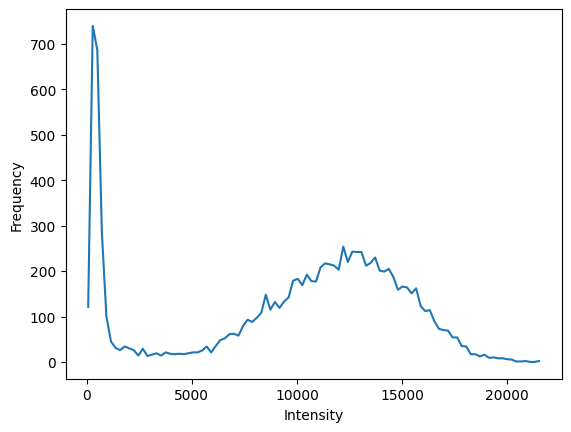

900it [00:00, 945.90it/s] 


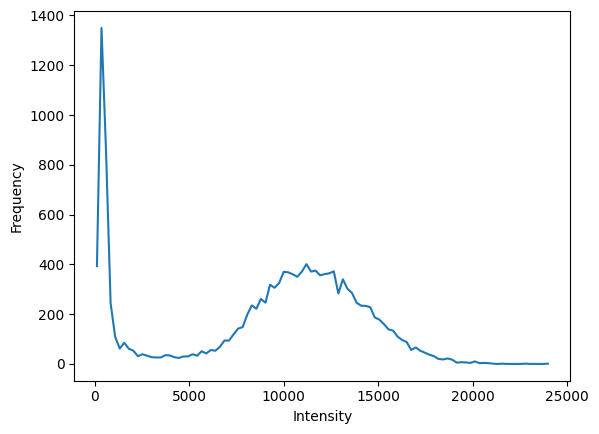

900it [00:00, 1118.92it/s]


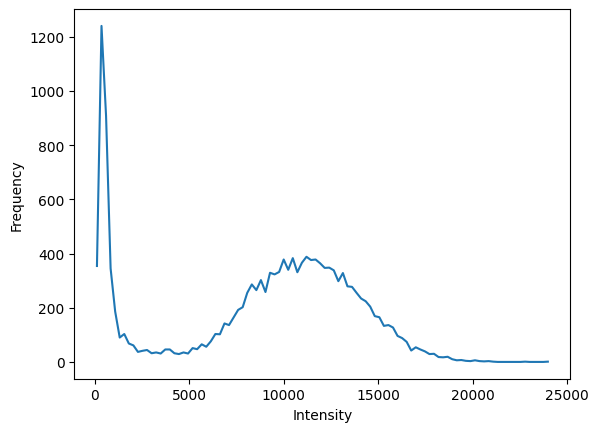

In [7]:
bead_peaks = {}
for df, video_path in zip([df1, df2, df3], [video_path1, video_path2, video_path3]):
    with TiffFile(video_path) as tif:
        for i, page in tqdm(enumerate(tif.pages)):
            frame = page.asarray()
            frame_df = df.loc[df['frame_number'] == i+1]
            box_list = []
            for index, row in frame_df.iterrows():
                box_list.append([row['x_center'], row['y_center'], row['width'], row['height']])
            for j, box in enumerate(box_list):
                x1, y1, x2, y2 = xywh_to_x1y1x2y2(box, frame.shape[1], frame.shape[0])
                if x2 - x1 < BEAD_WIDTH_THRESHOLD:
                    continue
                bead = frame[y1:y2, x1:x2]
                peaks, coords = get_2d_peaks(bead, 10)
                bead_peaks[f'frame_{i}_box_{j}'] = {'peaks': peaks, 'coords': coords}
    df_paeks = pd.DataFrame(bead_peaks).T
    p = np.concatenate(df_paeks['peaks'].values)
    hist, bins = np.histogram(p, bins=100)
    data = np.array([hist, bins[:-1]]).T
    plt.plot(data[:,1], data[:,0])
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.show()